# Visualizing high-dimensional data with PCA and t-SNE

We will follow this article: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b



In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from keras.datasets import mnist

(X, y), (X_test, y_test) = mnist.load_data()

X = X.reshape(X.shape[0], -1)

Using TensorFlow backend.
/home/marat/.pyenv/versions/3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import pandas as pd

feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]

df = pd.DataFrame(X,columns=feat_cols)
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i))

X, y = None, None

print('Size of the dataframe: {}'.format(df.shape))


Size of the dataframe: (60000, 785)


Because we dont want to be using 70,000 digits in some calculations we’ll take a random subset of the digits. The randomisation is important as the dataset is sorted by its label (i.e., the first seven thousand or so are zeros, etc.). To ensure randomisation we’ll create a random permutation of the number 0 to 69,999 which allows us later to select the first five or ten thousand for our calculations and visualisations.

In [3]:
rndperm = np.random.permutation(df.shape[0])

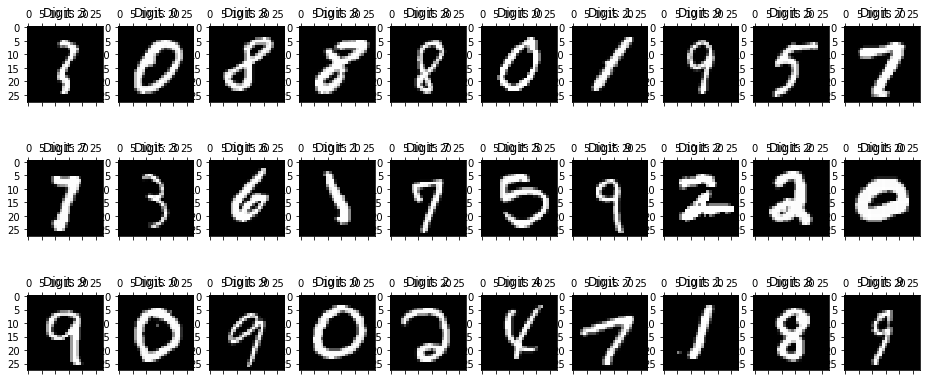

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot the graph
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,30):
    ax = fig.add_subplot(3,10,i+1, title='Digit: ' + str(df.loc[rndperm[i],'label']) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

# Dimensionality reduction using PCA

Since we as humans like our two- and three-dimensional plots lets start with that and generate, from the original 784 dimensions, the first three principal components. And we’ll also see how much of the variation in the total dataset they actually account for.

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [ 0.09704664  0.07095924  0.06169089]


/home/marat/.pyenv/versions/3.6.0/envs/machine-learning/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/marat/.pyenv/versions/3.6.0/envs/machine-learning/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp


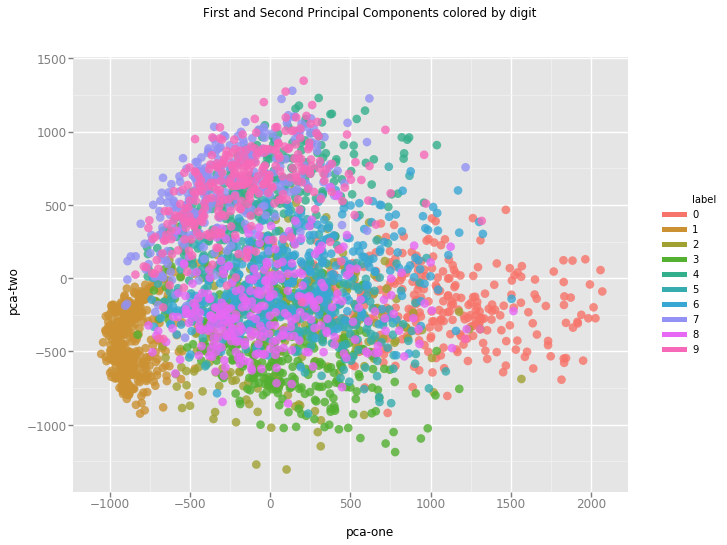

<ggplot: (-9223363246336451205)>

In [6]:
from ggplot import *

chart = ggplot( df.loc[rndperm[:3000],:], aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart

There is something around here, but it's not enough. Let's see what happens when we apply `t-SNE`

## T-Distributed Stochastic Neighbouring Entities (t-SNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. Contrary to PCA it is not a mathematical technique but a probablistic one. The original paper describes the working of t-SNE as:

“t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding”.

In [7]:
import time

from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.617s...
[t-SNE] Computed neighbors for 7000 samples in 69.210s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 461.155681
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.866478
[t-SNE] Error after 300 iterations: 2.569687
t-SNE done! Time elapsed: 142.83149766921997 seconds


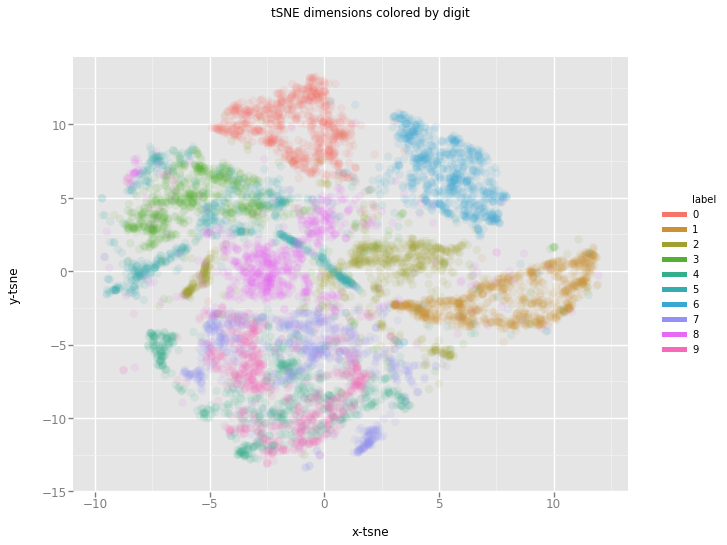

<ggplot: (8790516891484)>

In [8]:
df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

This is already a significant improvement over the PCA visualisation we used earlier. We can see that the digits are very clearly clustered in their own little group. If we would now use a clustering algorithm to pick out the seperate clusters we could probably quite accurately assign new points to a label.

We’ll now take the recommandations to heart and actually reduce the number of dimensions before feeding the data into the t-SNE algorithm. For this we’ll use PCA again. We will first create a new dataset containing the fifty dimensions generated by the PCA reduction algorithm. We can then use this dataset to perform the t-SNE on

In [9]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(df[feat_cols].values)
print('Cumulative explained variation for 50 principal components: {}'.format(
        np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.8245953389085932


In [ ]:
n_sne = 10000

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50[rndperm[:n_sne]])

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.019s...
[t-SNE] Computed neighbors for 10000 samples in 17.908s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 350.504580
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.689362
[t-SNE] Error after 300 iterations: 2.810949
t-SNE done! Time elapsed: 115.

In [ ]:
df_tsne = None
df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne-pca'] = tsne_pca_results[:,0]
df_tsne['y-tsne-pca'] = tsne_pca_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne-pca', y='y-tsne-pca', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by Digit (PCA)")
chart